# Machine Learning: Assignment 1

In [72]:
import numpy as np
import pandas as pd
import time
import gc
import random
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from yellowbrick.model_selection import LearningCurve, ValidationCurve
from sklearn.preprocessing import OneHotEncoder

# 1. Data Import, leansing Setup and helper functions

In [73]:
class Data():
    def dataAllocation(self,path):
        # df = pd.read_csv(path)
        # x_data = df.iloc[:, :-1]
        # y_data = df.iloc[:, -1 ]
        # return x_data,y_data
        X, y = make_classification(n_samples=2000, n_features=20, n_informative=10, n_redundant=0, random_state=rs)
        return X, y
    def trainSets(self,x_data,y_data):
        x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.3, random_state = rs, shuffle = True)
        return x_train, x_test, y_train, y_test

data = 'data/pima-indians-diabetes.csv'
rs = 614
dataset = Data()
x_data,y_data = dataset.dataAllocation(data)
x_train, x_test, y_train, y_test = dataset.trainSets(x_data,y_data)
# print("Heatmap for Features")
# data_corr = sns.heatmap(pd.DataFrame(x_train).corr(), cmap='Blues')

# 2. Decision Tree Classifier

In [74]:
class DTClassifier():

    def trainTest(self,x_train,x_test, y_train):
        df = []
        for i in range(16):
            for j in range(20):
                dt_clf = DecisionTreeClassifier(max_depth=i+1, min_samples_leaf=j+1)
                dt_clf.fit(x_train, y_train)
                
                y_predict_train = dt_clf.predict(x_train)
                y_predict_test = dt_clf.predict(x_test)
                df.append([i+1, j+1, "Train", f1_score(y_train, y_predict_train)])
                df.append([i+1, j+1, "Test", f1_score(y_test, y_predict_test)])

        return pd.DataFrame(df, columns=["Depth", "Leaf Size", "Sample Type", "F1 Score" ])
    
    def hyperParameterTuning(self,x_train,y_train):
        param_grid = {'max_depth': range(1, 21), 'min_samples_leaf': range(1, 20)}
        tuned = GridSearchCV(estimator = DecisionTreeClassifier(random_state = rs), param_grid = param_grid, cv=10)
        tuned.fit(x_train, y_train)
        print(tuned.best_params_)
        return tuned.best_score_, tuned.best_params_

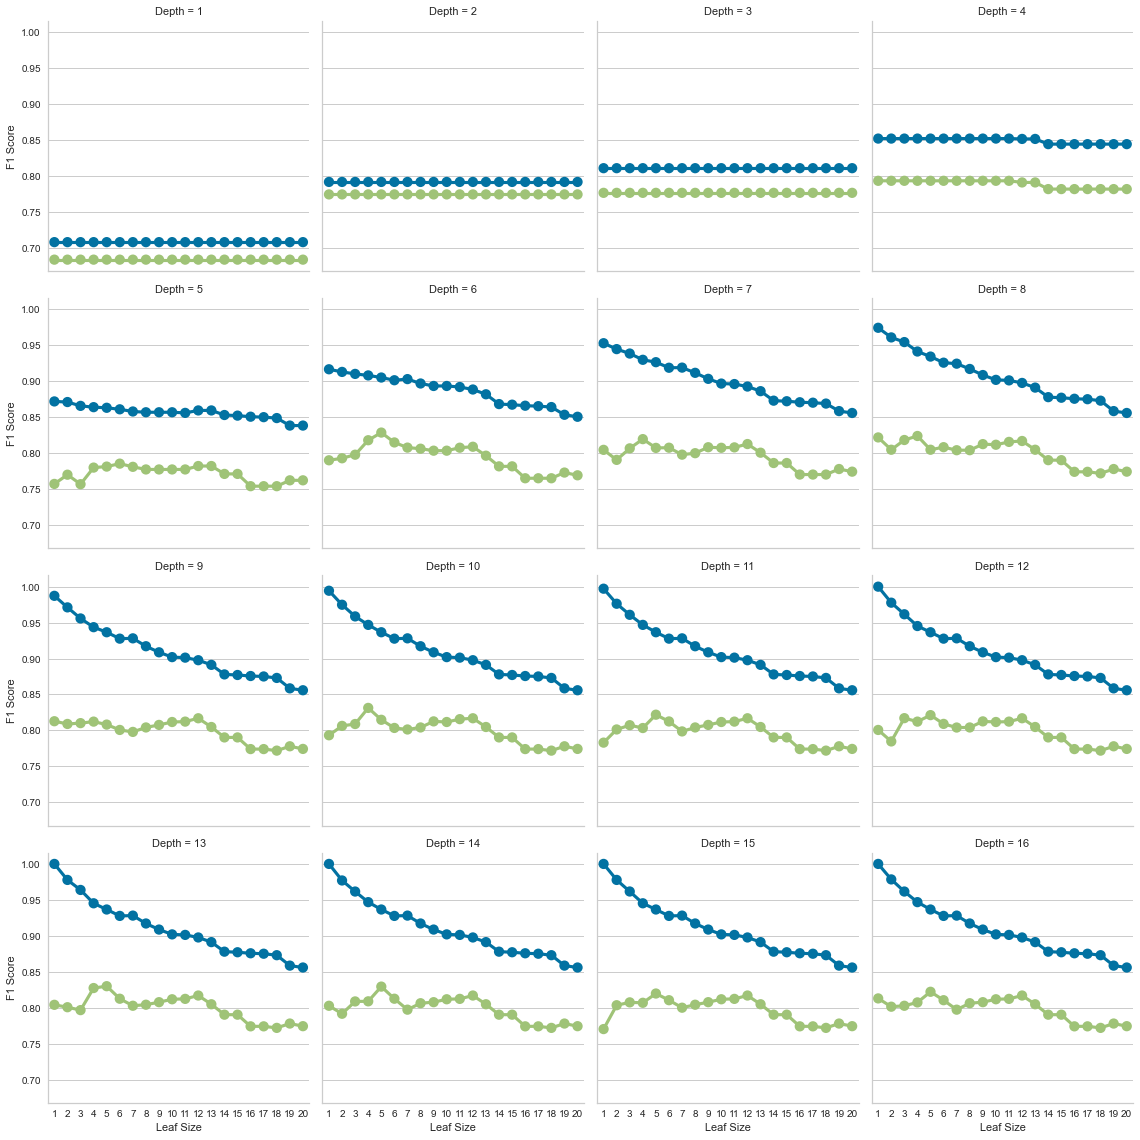

In [75]:
dt = DTClassifier()
df = dt.trainTest(x_train, x_test, y_train)
g = sns.FacetGrid(df, hue="Sample Type", col="Depth", height=4, col_wrap=4)
g.map(sns.pointplot, "Leaf Size", "F1 Score" )

In [78]:
best_score, best_params = dt.hyperParameterTuning(x_train,y_train)
print(best_score)

{'max_depth': 10, 'min_samples_leaf': 5}
0.8150000000000001


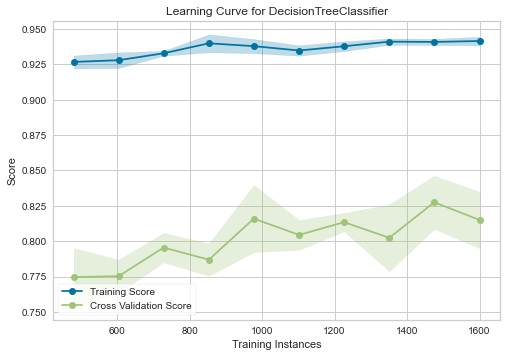

In [83]:
dt_tuned = DecisionTreeClassifier(max_depth=best_params['max_depth'], min_samples_leaf=best_params['min_samples_leaf'], random_state=rs)

sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    dt_tuned, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(x_data,y_data)        # Fit the data to the visualizer
visualizer.show()  

# 3. Support Vector Machine

In [89]:
class SupportVectorMachine():
    def dataPreProcess(self,x_train,x_test):
        scaler = StandardScaler()
        scaled_x_train = scaler.fit_transform(x_train)
        scaled_x_test = scaler.transform(x_test)
        return scaled_x_train, scaled_x_test
    
    def trainTest(self,scaled_x_train,scaled_x_test, y_train, y_test):
        cs = [x/10000 for x in [1, 10, 100, 1000, 10000, 100000, 1000000]]
        df = []
        for c in cs:
            for k in ["linear", "sigmoid"]:
                model = SVC(kernel = k, C=c)
                model.fit(scaled_x_train,y_train)
                y_predict_train = model.predict(scaled_x_train)
                y_predict_test = model.predict(scaled_x_test)
                df.append([k, c, accuracy_score(y_predict_test, y_test)])
        return pd.DataFrame(df, columns=["Kernel", "C", "Accuracy"])
        
    def hyperParameterTuning(self,scaled_x_train, y_train):
        param_grid = {'C': [x/10000 for x in [1, 10, 100, 1000, 10000, 100000, 1000000]],  
            'kernel': ["linear", "sigmoid"]}  
        svm_tune = SVC(gamma = "auto")
        svm_cv = GridSearchCV(estimator = svm_tune, param_grid = param_grid, n_jobs=5, return_train_score=True)
        svm_cv.fit(scaled_x_train, y_train)
        best_score = svm_cv.best_score_
        return best_score, svm_cv.best_params_

In [90]:
svm = SupportVectorMachine()
scaled_x_train, scaled_x_test = svm.dataPreProcess(x_train,x_test)
df = svm.trainTest(scaled_x_train,scaled_x_test, y_train, y_test)
best_score, best_params = svm.hyperParameterTuning(scaled_x_train, y_train)
print(best_score, best_params)

0.8614285714285714 {'C': 0.01, 'kernel': 'linear'}


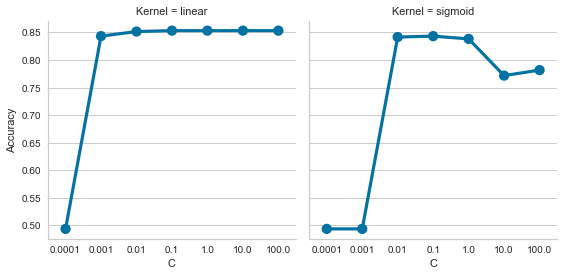

In [86]:
g = sns.FacetGrid(df, col="Kernel",  height=4)
g.map(sns.pointplot, "C", "Accuracy")

In [ ]:
dt_tuned = SVC(kernel=best_params['kernel'], C=best_params['C'])

sizes = np.linspace(0.3, 1.0, 10)

# Instantiate the classification model and visualizer
visualizer = LearningCurve(
    dt_tuned, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(x_data,y_data)        # Fit the data to the visualizer
visualizer.show()  

# 4. KNN

In [5]:
class KNN():
    def kNeighborsClassifier(self,x_train,x_test, y_train, n_neighbors):
        dt_clf = KNeighborsClassifier(n_neighbors = n_neighbors)
        dt_clf.fit(x_train, y_train)
        y_predict_train = dt_clf.predict(x_train)
        y_predict_test = dt_clf.predict(x_test)
        return dt_clf,y_predict_train, y_predict_test
    
    def dtTrainAccuracy(self,y_train,y_predict_train):
        train_accuracy = accuracy_score(y_predict_train, y_train)
        return train_accuracy
    
    def dtTestAccuracy(self,y_test,y_predict_test):
        test_accuracy = accuracy_score(y_predict_test, y_test)
        return test_accuracy

    def hyperParameterTuning(self,x_train,y_train):
        train_scores, test_scores = validation_curve(KNeighborsClassifier(), x_train, y_train, param_name="n_neighbors", param_range=range(1, 50), cv=5)
        return np.argmax(np.mean(test_scores, axis=1)) + 1
    
    
dt = KNN()
dt_clf,y_predict_train, y_predict_test = dt.kNeighborsClassifier(x_train,x_test, y_train, 3)
print("Decision Tree Train Accuracy: ",dt.dtTrainAccuracy(y_train,y_predict_train))
print("Decision Tree Test Accuracy: ",dt.dtTestAccuracy(y_test,y_predict_test))
n_neighbors_tuned = dt.hyperParameterTuning(x_train,y_train)
print("Optimal n_neighbors: ", n_neighbors_tuned)
dt_clf,y_predict_train, y_predict_test = dt.kNeighborsClassifier(x_train,x_test, y_train, n_neighbors_tuned)
print("Decision Tree Train Accuracy: ",dt.dtTrainAccuracy(y_train,y_predict_train))
print("Decision Tree Test Accuracy: ",dt.dtTestAccuracy(y_test,y_predict_test))


Decision Tree Train Accuracy:  0.9442857142857143
Decision Tree Test Accuracy:  0.8933333333333333
Optimal n_neighbors:  5
Decision Tree Train Accuracy:  0.9342857142857143
Decision Tree Test Accuracy:  0.9033333333333333


# 5. Neural Network

In [6]:
class NN():
    def dataPreProcess(self,x_train,x_test):
        scaler = StandardScaler()
        scaled_x_train = scaler.fit_transform(x_train)
        scaled_x_test = scaler.transform(x_test)
        return scaled_x_train, scaled_x_test

    def mlpClassifier(self,scaled_x_train,scaled_x_test, y_train):
        model = MLPClassifier(max_iter=100)

        model.fit(scaled_x_train,y_train)
        y_predict_train = model.predict(scaled_x_train)
        y_predict_test = model.predict(scaled_x_test)
        return y_predict_train, y_predict_test, model

    def mlpTrainAccuracy(self,y_train,y_predict_train):
        train_accuracy = accuracy_score(y_predict_train, y_train)
        return train_accuracy

    def mlpTestAccuracy(self,y_test,y_predict_test):
        test_accuracy = accuracy_score(y_predict_test, y_test)
        return test_accuracy
    
    def mlpBestScore(self, scaled_x_train, scaled_x_test, y_train, y_test, model):
        mlp_parameters = {
            'hidden_layer_sizes': [(10,30,10),(20,)],
            'activation': ['tanh', 'relu'],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
        }
        mlp_cv = GridSearchCV(model, mlp_parameters)
        mlp_cv.fit(scaled_x_train, y_train)
        return mlp_cv, mlp_cv.predict(scaled_x_test)
    
    def optimizedTestAccuracy(self,y_test,y_predict_test):
        test_accuracy = accuracy_score(y_predict_test, y_test)
        return test_accuracy 

nn = NN()
scaled_x_train, scaled_x_test = nn.dataPreProcess(x_train,x_test)
y_predict_train,y_predict_test, model = nn.mlpClassifier(scaled_x_train,scaled_x_test, y_train)
print("Neural Network Train Accuracy: ",nn.mlpTrainAccuracy(y_train,y_predict_train))
print("Neural Network Test Accuracy: ",nn.mlpTestAccuracy(y_test,y_predict_test))
nn_tuned, y_predict_test_optimized = nn.mlpBestScore(scaled_x_train, scaled_x_test, y_train, y_test, model)
print("Neural Network Optimized Test Accuracy: ", nn.optimizedTestAccuracy(y_test, y_predict_test_optimized))


Neural Network Train Accuracy:  0.9728571428571429
Neural Network Test Accuracy:  0.935
Neural Network Optimized Test Accuracy:  0.895


# 6. Boost

In [7]:
class Boost():
    def dataPreProcess(self,x_train,x_test):
        scaler = StandardScaler()
        scaled_x_train = scaler.fit_transform(x_train)
        scaled_x_test = scaler.transform(x_test)
        return scaled_x_train, scaled_x_test

    def gradientBoostingClassifier(self,scaled_x_train,scaled_x_test, y_train):
        model = GradientBoostingClassifier()

        model.fit(scaled_x_train,y_train)
        y_predict_train = model.predict(scaled_x_train)
        y_predict_test = model.predict(scaled_x_test)
        return y_predict_train, y_predict_test, model

    def gbTrainAccuracy(self,y_train,y_predict_train):
        train_accuracy = accuracy_score(y_predict_train, y_train)
        return train_accuracy

    def gbTestAccuracy(self,y_test,y_predict_test):
        test_accuracy = accuracy_score(y_predict_test, y_test)
        return test_accuracy
    

boost = Boost()
scaled_x_train, scaled_x_test = boost.dataPreProcess(x_train,x_test)
y_predict_train,y_predict_test, model = boost.gradientBoostingClassifier(scaled_x_train,scaled_x_test, y_train)
print("Boosting Train Accuracy: ",boost.gbTrainAccuracy(y_train,y_predict_train))
print("Boosting Test Accuracy: ",boost.gbTestAccuracy(y_test,y_predict_test))

Boosting Train Accuracy:  0.96
Boosting Test Accuracy:  0.8633333333333333
